Import the library

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error


检查分类列并转换为 category（如 `store_type`, `item_family`）

In [8]:
# 加载数据
DATA_DIR = (Path.cwd().parent / "data").resolve()   # …/Store-Sales---Time-Series-Forecasting/data
print("DATA_DIR =", DATA_DIR) # 返回数据目录路径
train_df  = pd.read_csv(DATA_DIR / "train.csv")
stores_df = pd.read_csv(DATA_DIR / "stores.csv")

# 检查列名
print("Train columns:", train_df.columns.tolist())
print("Stores columns:", stores_df.columns.tolist())

# 想要转为 category 类型的列
cat_cols_train = ['family']                # 商品类别
cat_cols_stores = ['type', 'city', 'state', 'cluster']  # 门店相关列

# train 中的 family
for col in cat_cols_train:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

# stores 中的类别列
for col in cat_cols_stores:
    if col in stores_df.columns:
        stores_df[col] = stores_df[col].astype('category')

# 验证类型
print("\ntrain_df info:")
print(train_df.info())

print("\nstores_df info:")
print(stores_df.info())

DATA_DIR = E:\la liste de programe\Py\Store\Store-Sales---Time-Series-Forecasting\data
Train columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Stores columns: ['store_nbr', 'city', 'state', 'type', 'cluster']

train_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype   
---  ------       -----   
 0   id           int64   
 1   date         object  
 2   store_nbr    int64   
 3   family       category
 4   sales        float64 
 5   onpromotion  int64   
dtypes: category(1), float64(1), int64(3), object(1)
memory usage: 117.3+ MB
None

stores_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 n

生成交叉特征 store_type × item_family

In [9]:
# store_type 在 stores.csv，item_family 在 train.csv

# 通过 store_nbr 这个共同的键，合并两个数据集（train_df 和 stores_df）
train_merged = train_df.merge(stores_df[['store_nbr', 'type']], on='store_nbr', how='left')

# 创建交叉特征列
train_merged['store_type_item_family'] = (
    train_merged['type'].astype(str) + "_" + train_merged['family'].astype(str)
)

# 结果
print(train_merged[['type', 'family', 'store_type_item_family']].head())

  type      family store_type_item_family
0    D  AUTOMOTIVE           D_AUTOMOTIVE
1    D   BABY CARE            D_BABY CARE
2    D      BEAUTY               D_BEAUTY
3    D   BEVERAGES            D_BEVERAGES
4    D       BOOKS                D_BOOKS


标记连续促销天数（基于 `is_promo` 列）

In [10]:
def mark_promo_streak(group: pd.DataFrame) -> pd.Series:
    """计算每个 (store_nbr, family) 的连续促销天数"""
    streak = pd.Series(0, index=group.index)
    current = 0
    for i in range(len(group)):
        if group.loc[group.index[i], "onpromotion"]:
            current += 1
        else:
            current = 0
        streak.iloc[i] = current
    return streak

# === 应用到每个门店-商品组合 ===
train_df = train_df.sort_values(["store_nbr", "family", "date"])
train_df["promo_streak"] = (
    train_df.groupby(["store_nbr", "family"], group_keys=False)
            .apply(mark_promo_streak)
)

# === 结果预览 ===
print("\n=== 连续促销天数示例 ===")
print(train_df[["store_nbr", "family", "date", "onpromotion", "promo_streak"]].head(10))

# === 一些统计信息 ===
print("\n=== 促销统计 ===")
print(f"最长连续促销天数: {train_df['promo_streak'].max()}")
print("\n促销持续天数分布:")
print(train_df.loc[train_df["promo_streak"] > 0, "promo_streak"]
      .value_counts()
      .sort_index()
      .head())

C:\Users\dell\AppData\Local\Temp\ipykernel_10908\932373681.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(["store_nbr", "family"], group_keys=False)



=== 连续促销天数示例 ===
       store_nbr      family        date  onpromotion  promo_streak
0              1  AUTOMOTIVE  2013-01-01            0             0
1782           1  AUTOMOTIVE  2013-01-02            0             0
3564           1  AUTOMOTIVE  2013-01-03            0             0
5346           1  AUTOMOTIVE  2013-01-04            0             0
7128           1  AUTOMOTIVE  2013-01-05            0             0
8910           1  AUTOMOTIVE  2013-01-06            0             0
10692          1  AUTOMOTIVE  2013-01-07            0             0
12474          1  AUTOMOTIVE  2013-01-08            0             0
14256          1  AUTOMOTIVE  2013-01-09            0             0
16038          1  AUTOMOTIVE  2013-01-10            0             0

=== 促销统计 ===
最长连续促销天数: 363

促销持续天数分布:
promo_streak
1    127936
2     47470
3     29790
4     21968
5     17511
Name: count, dtype: int64


C:\Users\dell\AppData\Local\Temp\ipykernel_10908\932373681.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df.groupby(["store_nbr", "family"], group_keys=False)


总销售量随时间变化折线图

C:\Users\dell\AppData\Local\Temp\ipykernel_10908\1631649001.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(["date", "family"])["sales"]


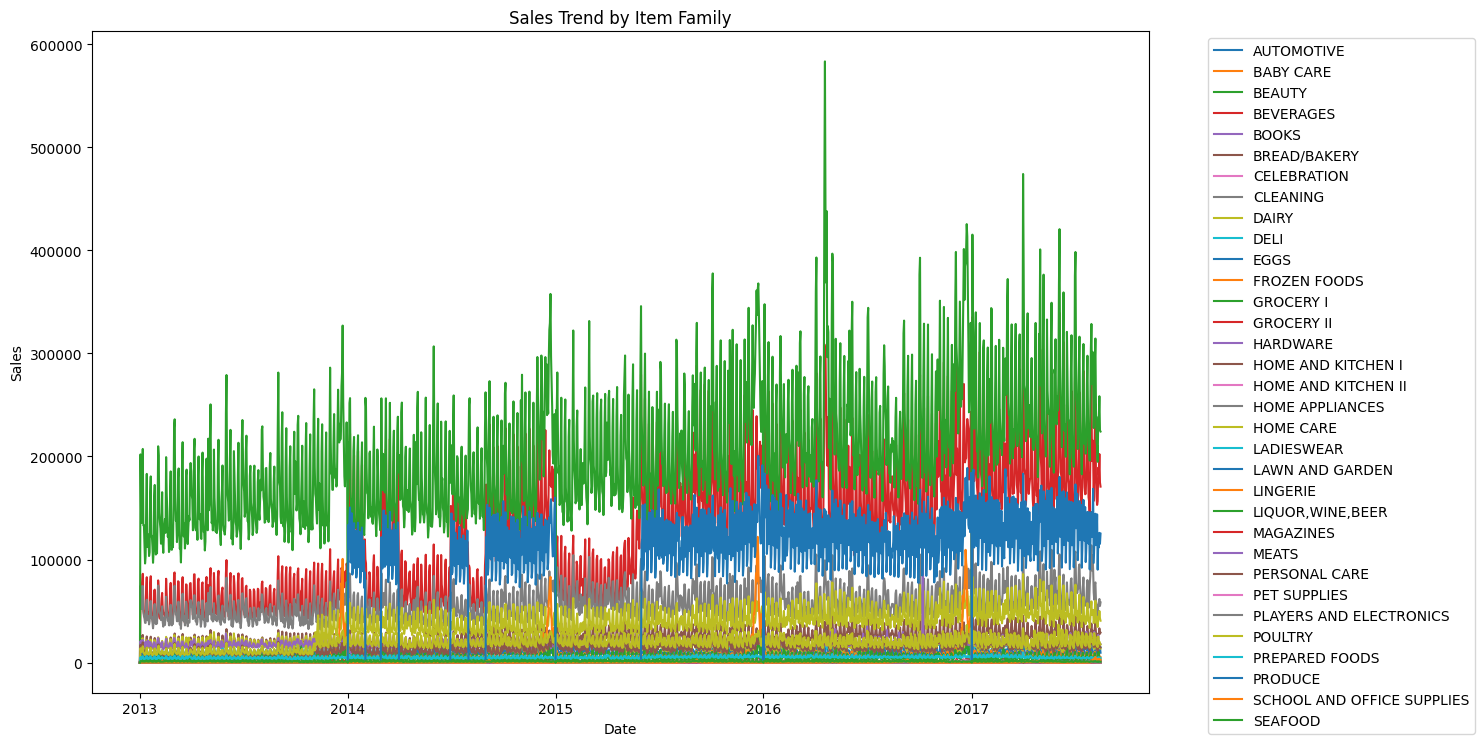

In [11]:
train_df["date"] = pd.to_datetime(train_df["date"])

df_family = (
    train_df.groupby(["date", "family"])["sales"]
            .sum()
            .reset_index()
)

plt.figure(figsize=(15, 8))

for fam in df_family["family"].unique():
    sub = df_family[df_family["family"] == fam]
    plt.plot(sub["date"], sub["sales"], label=fam)

plt.title("Sales Trend by Item Family")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../figures/item_family_sales.jpg", dpi=300, bbox_inches="tight")
plt.show()

节假日销售对比图（`holidays_events.csv`）

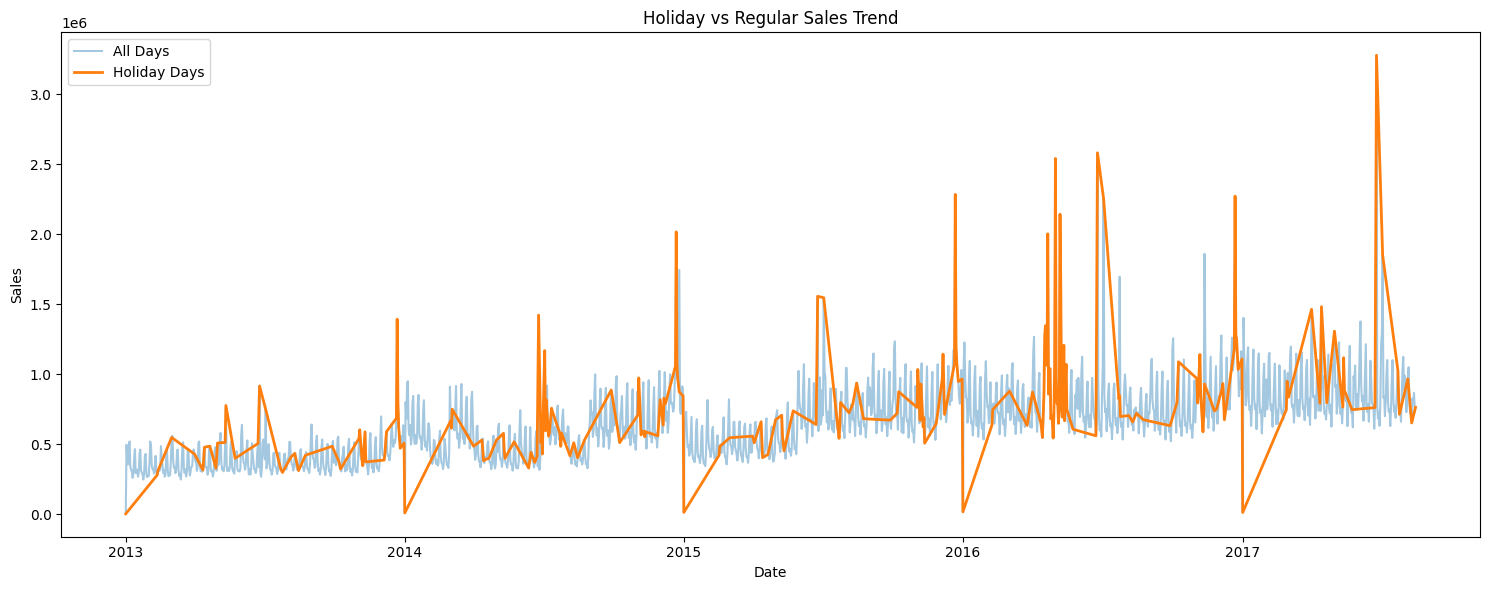

In [12]:
holidays_df = pd.read_csv(DATA_DIR / "holidays_events.csv")
holidays_df["date"] = pd.to_datetime(holidays_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

df = train_df.merge(
    holidays_df[["date", "type", "locale", "description"]],
    on="date",
    how="left"
)

holiday_types = ["Holiday", "Event", "Additional"]
df_holiday = df[df["type"].isin(holiday_types)]

daily_sales = df.groupby("date")["sales"].sum().reset_index()

holiday_sales = (
    df_holiday.groupby("date")["sales"].sum().reset_index()
)

plt.figure(figsize=(15, 6))

plt.plot(daily_sales["date"], daily_sales["sales"],
         label="All Days", alpha=0.4)

plt.plot(holiday_sales["date"], holiday_sales["sales"],
         label="Holiday Days", linewidth=2)

plt.title("Holiday vs Regular Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/holiday_vs_regular_sales.jpg", dpi=300, bbox_inches="tight")
plt.show()


交易量与销售量热力图

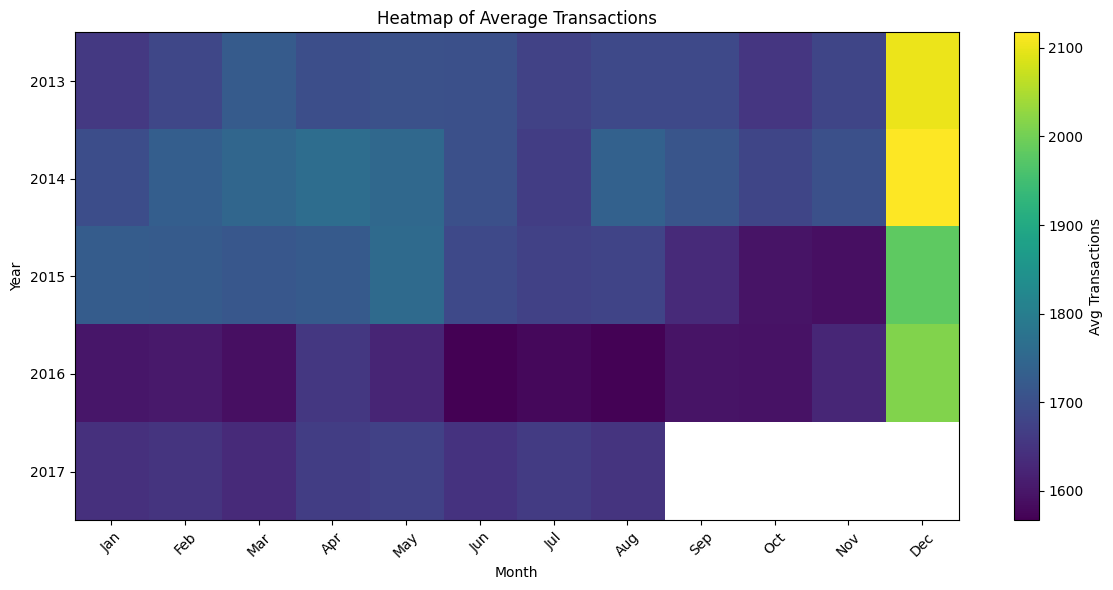

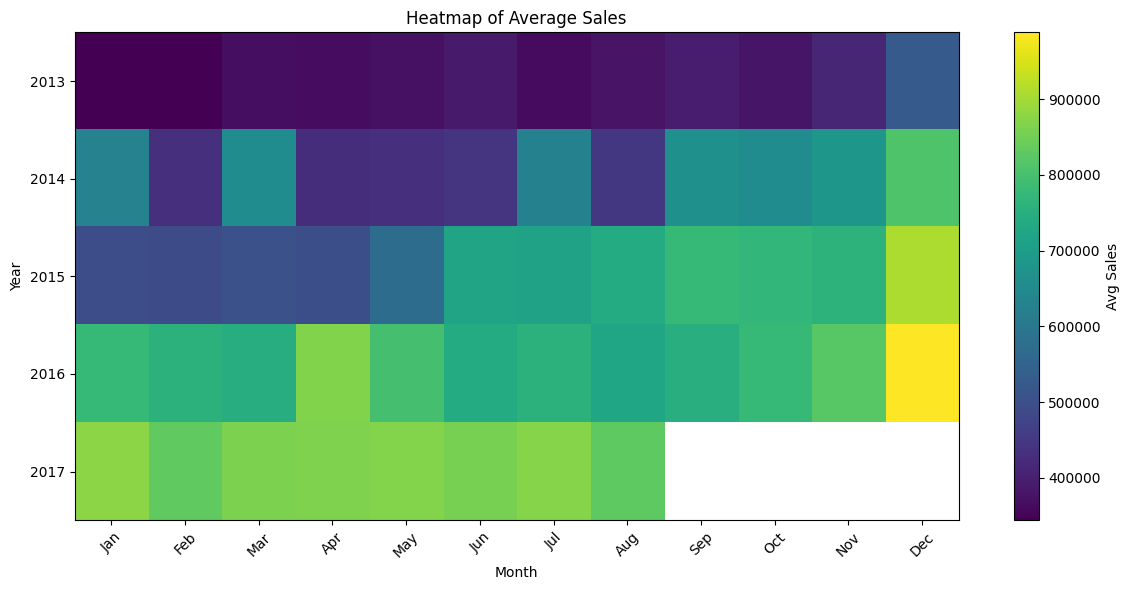

In [13]:
transactions_df = pd.read_csv(DATA_DIR / "transactions.csv")
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_ts = sales_daily.merge(transactions_df, on="date", how="left")

df_ts["year"] = df_ts["date"].dt.year
df_ts["month"] = df_ts["date"].dt.month

pivot_trans = df_ts.pivot_table(
    index="year", columns="month",
    values="transactions", aggfunc="mean"
)

pivot_sales = df_ts.pivot_table(
    index="year", columns="month",
    values="sales", aggfunc="mean"
)

def plot_heatmap(pivot_df, title, label, filename):
    plt.figure(figsize=(12, 6))
    data = pivot_df.values
    im = plt.imshow(data, cmap="viridis", aspect="auto")
    cbar = plt.colorbar(im)
    cbar.set_label(label)

    plt.xticks(
        np.arange(12),
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        rotation=45
    )
    plt.yticks(np.arange(len(pivot_df.index)), pivot_df.index)

    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

plot_heatmap(
    pivot_trans,
    "Heatmap of Average Transactions",
    "Avg Transactions",
    "transactions_heatmap.jpg"
)

plot_heatmap(
    pivot_sales,
    "Heatmap of Average Sales",
    "Avg Sales",
    "sales_heatmap.jpg"
)

油价与销售量散点图

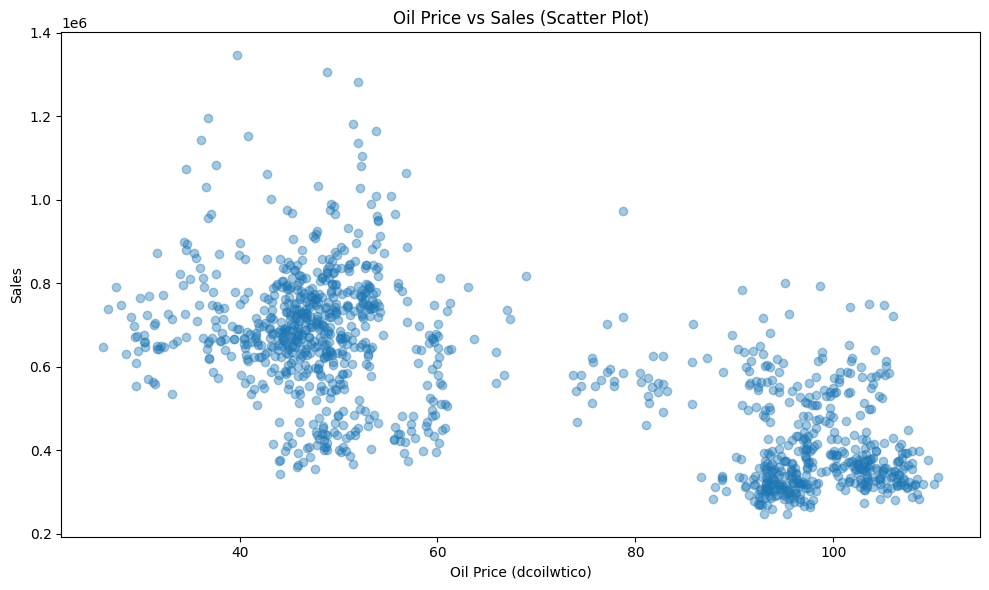

In [14]:
oil_df = pd.read_csv(DATA_DIR / "oil.csv")
oil_df["date"] = pd.to_datetime(oil_df["date"])

train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_oil = sales_daily.merge(oil_df, on="date", how="left")

plt.figure(figsize=(10, 6))

plt.scatter(df_oil["dcoilwtico"], df_oil["sales"], alpha=0.4)

plt.title("Oil Price vs Sales (Scatter Plot)")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Sales")
plt.tight_layout()
plt.savefig("../figures/oil_vs_sales_scatter.jpg", dpi=300, bbox_inches="tight")
plt.show()

构建时间序列模型（SARIMA）预测销售

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -21540.838
Date:                           Fri, 30 Jan 2026   AIC                          43093.675
Time:                                   14:25:45   BIC                          43126.203
Sample:                               01-01-2013   HQIC                         43105.728
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion    48.8403      1.268     38.525      0.000      46.356      51.325
ar.L1           0.5159      0.027     19

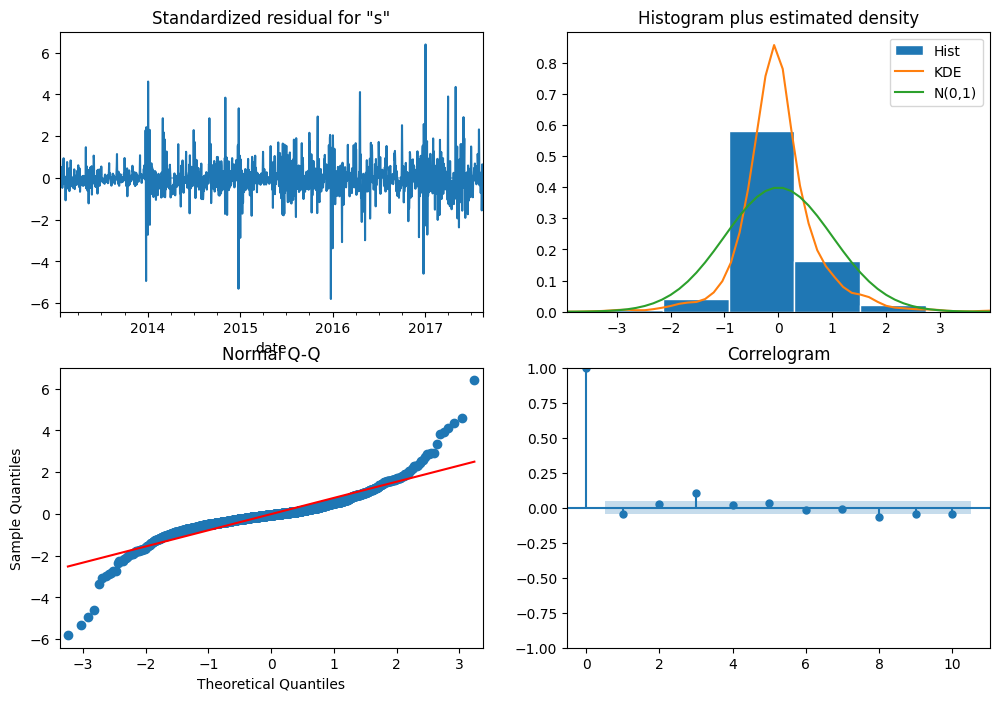

In [16]:
# 1) 每日总销量
train_df["date"] = pd.to_datetime(train_df["date"])

daily_sales = (
    train_df
    .groupby("date", as_index=False)["sales"]
    .sum()
)

ts = (
    daily_sales
    .set_index("date")
    .asfreq("D")["sales"]
    .fillna(0.0)
)

# 2) 外生变量 exog
exog = (
    train_df
    .groupby("date", as_index=False)["onpromotion"]
    .sum()
    .set_index("date")
    .reindex(ts.index)
    .fillna(0.0)
)


# 3) 拟合 SARIMAX
sarimax_model = SARIMAX(
    ts,
    exog=exog,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),  # 周季节性
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)

# 4) 输出摘要 + 残差诊断
print(sarimax_results.summary())

sarimax_results.plot_diagnostics(figsize=(12, 8))
plt.show()


In [18]:
#读取 test.csv
test_df = pd.read_csv(DATA_DIR / "test.csv")
test_df["date"] = pd.to_datetime(test_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

#生成 is_holiday（日级别节假日指示变量）
holiday_types = ["Holiday", "Event", "Additional"]
holiday_flag = (
    holidays_df[holidays_df["type"].isin(holiday_types)][["date"]]
    .drop_duplicates()
    .assign(is_holiday=1)
)

#统一特征构造函数
def build_features(base_df: pd.DataFrame) -> pd.DataFrame:
    df_feat = base_df.copy()

    # merge store type
    df_feat = df_feat.merge(stores_df[["store_nbr", "type"]], on="store_nbr", how="left")

    # holiday flag
    df_feat = df_feat.merge(holiday_flag, on="date", how="left")
    df_feat["is_holiday"] = df_feat["is_holiday"].fillna(0).astype(int)

    # transactions
    df_feat = df_feat.merge(transactions_df, on=["date", "store_nbr"], how="left")

    # oil
    df_feat = df_feat.merge(oil_df, on="date", how="left")

    # time features
    df_feat["year"] = df_feat["date"].dt.year
    df_feat["month"] = df_feat["date"].dt.month
    df_feat["day"] = df_feat["date"].dt.day
    df_feat["weekday"] = df_feat["date"].dt.weekday

    # cross feature（你在 Cell 5 做过类似的；这里不依赖 train_merged，直接生成）
    df_feat["store_type_item_family"] = (
        df_feat["type"].astype(str) + "_" + df_feat["family"].astype(str)
    )

    # 缺失值处理（LightGBM 对 NaN 友好，但这里把明显的空补一下更稳）
    if "transactions" in df_feat.columns:
        df_feat["transactions"] = df_feat["transactions"].fillna(0)
    if "dcoilwtico" in df_feat.columns:
        df_feat["dcoilwtico"] = df_feat["dcoilwtico"].fillna(method="ffill").fillna(method="bfill")

    # onpromotion 可能存在于 test/train
    if "onpromotion" in df_feat.columns:
        df_feat["onpromotion"] = df_feat["onpromotion"].fillna(0)

    return df_feat

train_feat = build_features(train_df)
test_feat  = build_features(test_df)

#选择特征列
drop_cols = ["date", "sales"]
feature_cols = [c for c in train_feat.columns if c not in drop_cols]

# 保证 test 也有这些列
feature_cols = [c for c in feature_cols if c in test_feat.columns]

# 类别列
cat_cols = []
for c in ["store_nbr", "family", "type", "store_type_item_family"]:
    if c in feature_cols:
        cat_cols.append(c)
        train_feat[c] = train_feat[c].astype("category")
        test_feat[c] = test_feat[c].astype("category")

#训练/验证切分
last_date = train_feat["date"].max()
valid_start = last_date - pd.Timedelta(days=15)

train_mask = train_feat["date"] < valid_start
valid_mask = train_feat["date"] >= valid_start

X_train = train_feat.loc[train_mask, feature_cols]
y_train = np.log1p(train_feat.loc[train_mask, "sales"].astype(float))

X_valid = train_feat.loc[valid_mask, feature_cols]
y_valid = np.log1p(train_feat.loc[valid_mask, "sales"].astype(float))

#训练 LightGBM（回归）
model = lgb.LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    n_estimators=5000,
    num_leaves=128,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_cols if len(cat_cols) > 0 else "auto",
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

#验证集 RMSLE（在原尺度上算）
valid_pred = np.expm1(model.predict(X_valid, num_iteration=model.best_iteration_))
valid_true = train_feat.loc[valid_mask, "sales"].astype(float).values
valid_pred = np.maximum(valid_pred, 0.0)

rmsle = np.sqrt(mean_squared_log_error(valid_true, valid_pred))
print("Validation RMSLE =", rmsle)

#全量训练
X_full = train_feat[feature_cols]
y_full = np.log1p(train_feat["sales"].astype(float))

final_model = lgb.LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    n_estimators=int(model.best_iteration_ * 1.2),
    num_leaves=128,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

final_model.fit(
    X_full, y_full,
    categorical_feature=cat_cols if len(cat_cols) > 0 else "auto"
)

#预测 test 并导出提交
X_test = test_feat[feature_cols]
test_pred = np.expm1(final_model.predict(X_test))
test_pred = np.maximum(test_pred, 0.0)

submission = pd.DataFrame({
    "id": test_feat["id"].astype(int),
    "sales": test_pred
})

submission.to_csv("submission_lgbm.csv", index=False)
print("Saved: submission_lgbm.csv")
submission.head()


C:\Users\dell\AppData\Local\Temp\ipykernel_10908\3080213890.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat["dcoilwtico"] = df_feat["dcoilwtico"].fillna(method="ffill").fillna(method="bfill")
C:\Users\dell\AppData\Local\Temp\ipykernel_10908\3080213890.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat["dcoilwtico"] = df_feat["dcoilwtico"].fillna(method="ffill").fillna(method="bfill")


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 2972376, number of used features: 13
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Start training from score 2.919643
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2069]	valid_0's rmse: 0.387156	valid_0's l2: 0.14989
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will 

,id,sales
0,3000888,0.325380
1,3000889,0.000000
2,3000890,3.246428
3,3000891,228.080889
4,3000892,0.000000


对验证集生成预测

In [19]:
# 验证集预测分析表
# 1) 取验证集特征
X_valid = train_feat.loc[valid_mask, feature_cols]

# 2) 生成验证集预测
valid_pred = np.expm1(model.predict(X_valid, num_iteration=model.best_iteration_))
valid_pred = np.maximum(valid_pred, 0.0)

# 3) 取真实值
valid_true = train_feat.loc[valid_mask, "sales"].astype(float).values

# 4) 拼出可分析表
keep_cols = []
for c in ["date", "store_nbr", "family"]:
    if c in train_feat.columns:
        keep_cols.append(c)

valid_pred_df = train_feat.loc[valid_mask, keep_cols].copy()
valid_pred_df["y_true"] = valid_true
valid_pred_df["y_pred"] = valid_pred
valid_pred_df["error"] = valid_pred_df["y_pred"] - valid_pred_df["y_true"]
valid_pred_df["abs_error"] = np.abs(valid_pred_df["error"])

# 5) 排序
if "date" in valid_pred_df.columns:
    valid_pred_df = valid_pred_df.sort_values("date").reset_index(drop=True)

# 6) 导出
valid_pred_df.to_csv("valid_predictions_lgbm.csv", index=False)
print("Saved: valid_predictions_lgbm.csv")
valid_pred_df.head()


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Saved: valid_predictions_lgbm.csv


,date,store_nbr,family,y_true,y_pred,error,abs_error
0,2017-07-31,1,AUTOMOTIVE,8.0,4.293033,-3.706967,3.706967
1,2017-07-31,26,MAGAZINES,0.0,0.288028,0.288028,0.288028
2,2017-07-31,26,"LIQUOR,WINE,BEER",2.0,7.616733,5.616733,5.616733
3,2017-07-31,4,LADIESWEAR,15.0,16.014552,1.014552,1.014552
4,2017-07-31,26,LINGERIE,0.0,0.940726,0.940726,0.940726


In [20]:
import random, os, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
